#NLP with Disater Tweets Kaggle Mini-Project

This project explores building a Recurrent Neural Network (RNN) for Natural Language Processing (NLP) of tweets with the goal of determining if a tweet is about a natural disaster. At the time of writing, this project is the week 4 assignment for "DTSA 5511: Introduction to Deep Learning".

 This notebook, datasets, and output files can be accessed from my github repository [here](https://github.com/arwhit/NLP-Disaster-Tweets).

You can read more about the kaggle competition [here](https://www.kaggle.com/competitions/nlp-getting-started/overview).

In [ ]:
#Import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import keras
from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, BatchNormalization, Activation
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Data Description
The training dataset contains 7613 observances with 5 columns:
  1. id-unique identifier for the tweet
  2. keyword- predefined keyword in tweet
  3. location- location of tweet
  4. text- actual tweet content
  5. target- indicates if tweet is about a disaster (1) or something else (0)


You can see from the preview below that many of the keywords and locations may be missing. This will be addressed in a later section.

The test dataset contains 3263 observances with 4 of the above mentioned columns. The test dataset contains no target label since the test datset predictions will be evalauted against a known label when the output file is submitted to kaggle.

In [ ]:
#Import Dataset
train_url='https://raw.githubusercontent.com/arwhit/NLP-Disaster-Tweets/main/disaster_tweets_train.csv'
test_url='https://raw.githubusercontent.com/arwhit/NLP-Disaster-Tweets/main/disaster_tweets_test.csv'
train_df=pd.read_csv(train_url)
test_df=pd.read_csv(test_url)

train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##EDA, Data Cleaning, and Preprocessing

Let's take a look at the dataset. We can see that there are no missing values in the id, text, or target columns. It is also noted that there are a few missing values in keywords and roughly 1/3 of all location values are missing. We also see that around 4000 observances are not classified as disaster tweets and roughly 3000 observances are about disasters.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


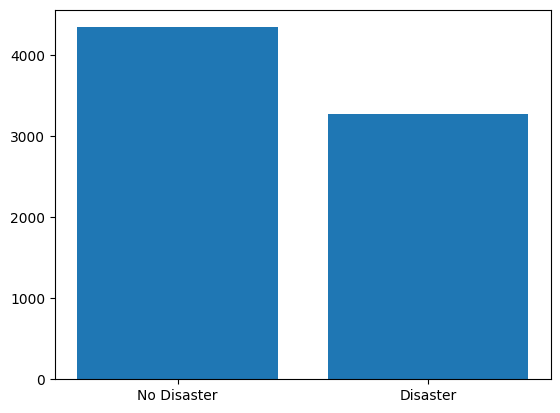

In [ ]:
x=['No Disaster','Disaster']
y=[train_df['target'].value_counts()[0],train_df['target'].value_counts()[1]]
plt.bar(x,y)
plt.show()

While keywords might be redundant for model building, they might be useful to get an idea of what words are prevelant in disaster tweets. If we sort the keywords in decending order, we see that ablaze and accident are the most occuring words.

In [ ]:
# Create list of keywords
unique_values =train_df[train_df['target'] == 1]['keyword'].unique().tolist()
unique_values.pop(0)
# Count number of occurances
counts =train_df[train_df['target'] == 1]['keyword'].value_counts().tolist()
#create the df and sort in decending order
word_df=pd.DataFrame({'word':unique_values, 'counts':counts})
top_words=word_df.sort_values(by='counts', ascending=False).head(10)
top_words

,word,counts
0,ablaze,39
2,airplane%20accident,39
1,accident,39
3,ambulance,37
5,annihilation,37
4,annihilated,37
6,apocalypse,32
8,army,32
9,arson,32
7,armageddon,32


We need to think about all those missing values as well as the utility of the keyword and location columns.

Less than 10% of the keywords are missing, so it could be argued that there are enough values to include them in the model. However, it is unclear how the keywords were determined. The keyword might also be considered redundant since it is simply a word that was extracted from the overall text. If we build a model with multiple layers, we would expect the model to pick up on keywords even if we do not explicitly assign them. For this reason, we will drop the keywords column.

Since roughly one third of the location column is missing data and the location of past disasters is not necessarily indicative of future disasters happening in those locations, we will also drop the location column

In [ ]:
train_df=train_df.drop(['keyword', 'location'], axis=1)
test_df=test_df.drop(['keyword', 'location'], axis=1)

The text content can easily be vectorized using packages within the Keras library without much preprocessing. However, some preproccesing will be done outside of Keras using NLTK as it has more robust features for removing stopwords and numbers.

In [ ]:
#create cleaner function utlizing NLTK
def text_cleaner(tweet):
  #make all the words lowercase
  tweet=word_tokenize(tweet.lower())
  #specify stopwords to omit
  stop_words = set(stopwords.words('english'))
  #return a list of words that omits stop words, punctuation, and numbers
  cleaned_words = [word for word in tweet if word.isalpha() and not word in stop_words]
  #combine the indiduals words into a single string
  cleaned_tweet=' '.join(cleaned_words)
  return cleaned_tweet

#clean training dataset
for i in range(len(train_df)):
  train_df.loc[i, 'text'] = text_cleaner(train_df.loc[i, 'text'])

#clean test dataset
for i in range(len(test_df)):
  test_df.loc[i, 'text'] = text_cleaner(test_df.loc[i, 'text'])

In [ ]:
#print example output
train_df['text'][10]

'three people died heat wave far'

Lastly, we will convert the tweets and labels into the format needed to pass them into the model. Since we do not know the true labels of the test dataset and submitting the file to kaggle to recieve an accuracy score is somewhat ambiguous, we will also create a validation set from the training dataset so we can better observe/monitor any overfitting that might be happening.

In [ ]:
train=train_df.sample(frac=0.8,random_state=5)
training_data=np.array(train['text'])
training_labels=np.array(train['target'])
val=train_df.drop(train.index)
validation_data=np.array(val['text'])
validation_labels=np.array(val['target'])
test_data=np.array(test_df['text'])

## Model Building and Hyperparemter Tuning
Now that we have a better understanding of the dataset and have preprocessed the data, let's construct the models. Hyperparamter tuning will be conducted on the normalization methods. The 3 models are as follows:

1. Model 1: LSTM with ADAM and no normalization
2. Model 2: LSTM with ADAM and Batch Normalization
3. Model 3: LSTM with ADAM and Dropout Normalization




In [ ]:
# Prepare a TextVectorization layer
vectorizer = TextVectorization(output_mode="int",max_tokens=5000)
vectorizer.adapt(training_data)
vectorized_training_data =vectorizer(training_data)
vectorized_validation_data=vectorizer(validation_data)
vectorized_test_data=vectorizer(test_data)

#model 1: ADAM and no Normalization
model1 = keras.Sequential()
# Add an Embedding layer expecting input of the vecotrized vocab
model1.add(Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=100, mask_zero=True))
# Add a LSTM layer
model1.add(LSTM(100,batch_size=50))
# Add Dense layers
model1.add(Dense(10, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         500000    
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 10)                1010      
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 581,421
Trainable params: 581,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model 2: ADAM and Batch Normalization
model2 = keras.Sequential()
# Add an Embedding layer expecting input of the vecotrized vocab
model2.add(Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=100, mask_zero=True))
# Add a LSTM layer
model2.add(LSTM(100,batch_size=50))
model2.add(BatchNormalization())
# Add Dense layers
model2.add(Dense(10, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         500000    
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 10)                1010      
                                                                 
 batch_normalization_5 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 1)                

In [ ]:
#model 3: ADAM and Dropout Normalization
model3 = keras.Sequential()
# Add an Embedding layer expecting input of the vecotrized vocab
model3.add(Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=100, mask_zero=True))
# Add a LSTM layer
model3.add(LSTM(100,batch_size=50))
#Add dropout layer
model3.add(Dropout(rate=0.5))
# Add Dense layer
model3.add(Dense(10, activation='relu'))
#add dropout layer
model3.add(Dropout(rate=0.5))
# Add Dense layer
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         500000    
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 10)                1010      
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 581,421
Trainable params: 581,421
Non-tr

In [ ]:
#Compile the models
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Train the model
history1=model1.fit(vectorized_training_data, training_labels,
                    validation_data=(vectorized_validation_data,validation_labels),
                    epochs=10,
                    verbose=0)
history2=model2.fit(vectorized_training_data, training_labels,
                    validation_data=(vectorized_validation_data,validation_labels),
                    epochs=10,
                    verbose=0)
history3=model3.fit(vectorized_training_data, training_labels,
                    validation_data=(vectorized_validation_data,validation_labels),
                    epochs=10,
                    verbose=0)

In [ ]:
#Make Predictions on Test Datasets and export to CSV for kaggle submission
m1_preds=np.round(model1.predict(vectorized_test_data)).ravel().tolist()
id=test_df['id'].tolist()
t1=m1_preds
m1df=pd.DataFrame({'id':id,'target':t1}).astype(int)
m1df.to_csv('no_normalization.csv', index=False)
files.download('no_normalization.csv')

m2_preds=np.round(model2.predict(vectorized_test_data)).ravel().tolist()
t2=m2_preds
m2df=pd.DataFrame({'id':id,'target':t2}).astype(int)
m2df.to_csv('batch_normalization.csv', index=False)
files.download('batch_normalization.csv')

m3_preds=np.round(model3.predict(vectorized_test_data)).ravel().tolist()
t3=m3_preds
m3df=pd.DataFrame({'id':id,'target':t3}).astype(int)
m3df.to_csv('dropout.csv', index=False)
files.download('dropout.csv')


102/102 [==============================] - 1s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

102/102 [==============================] - 1s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

102/102 [==============================] - 1s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results and Analysis
Let's see how each model performed on the training and validation data

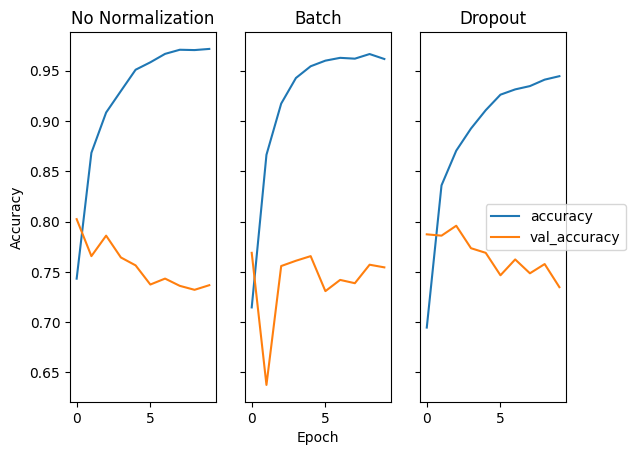

In [ ]:
#Accuracy Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
ax1.plot(history1.history['accuracy'])
ax1.plot(history1.history['val_accuracy'])
ax1.set_title('No Normalization')

ax2.plot(history2.history['accuracy'])
ax2.plot(history2.history['val_accuracy'])
ax2.set_title('Batch')

ax3.plot(history3.history['accuracy'])
ax3.plot(history3.history['val_accuracy'])
ax3.set_title('Dropout')

ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
fig.legend(['accuracy','val_accuracy'], loc='center right',)

These are the results of the test dataset that were submitted to Kaggle. Note, this score represents the F1 score, not the accuracy
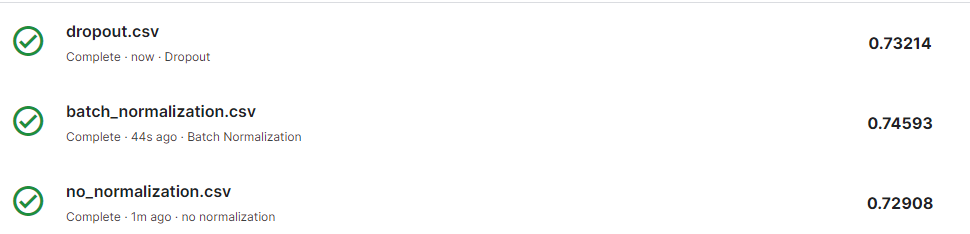


For this dataset batch normalization appear to slightly mitigate overfitting at higher epochs while the effects of dropout on overfitting are less clear. It appears models at lesser epochs achieve the same, or better, validation accuracy than models at larger epochs. Training accuracy appears to level out around the 5th epoch.

The highest validation accuracy was 80.2% and was achieved by the model without normalization at the 1st epoch.

The model with the lowest validation accuracy 63.8% and was achieved by the batch normalization model at the second epoch.

The model with the highest accuracy was 97.2% (epoch 10 of the model without regularization) but significant overfitting was present.

The batch normalization model yielded the highest F1 score, 74.6%, on the kaggle test dataset.

##Conclusions
In conclusion, it appears RNN, specifically LSTM, can be used effectively to predict text with predefined classes. However, there is still room for improvement. This is the first deep learning project I have worked on, but I suspect the archtechture needs to be revisited as it seems unusual for training accuracy of the 1st epoch to be the highest as this would imply every subsequent model was overfitting.

If I were to work on the project further, I would tune different optimization methods in addition to the regularization method. I might also test a different architechture like a gated recurrent unit (GRU).

###Sources
https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook

https://www.atmosera.com/blog/text-classification-with-neural-networks/

https://keras.io/getting_started/intro_to_keras_for_engineers/

https://www.tensorflow.org/text/tutorials/text_classification_rnn